In [1]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt


taul = 25
tau_up = 20
dtaui = tau_up/taul
taui = np.linspace(0.001, tau_up - dtaui - 0.001,num=taul)
# taui = torch.linspace(0, tau_up-dtaui,steps=taul).to(device)


omegal = 500
omega_up = 20
domegai = omega_up/omegal
# omegai = torch.linspace(domegai ,omega_up,steps=omegal).to(device) #,requires_grad=True

omegai = np.linspace(domegai ,omega_up ,num=omegal) #,requires_grad=True

# input = omegai.reshape(-1)
input = np.ones(1) # ,requires_grad=True

import math
def chi2(pre,obs):
    out = (obs - pre)**2
    out = out.sum()
    return out #.mean()
def par_chi2(pre,obs):
    delta = obs.mean()
    out = (obs - pre)/(obs - delta)**2
    return out
def D(taui,omegai,rhoi):
    Kkl = np.zeros((taul,omegal))
    for n in range(taul):
        for m in range(omegal):
            Kkl[n][m] = (omegai[m]/(omegai[m]**2 +taui[n]**2))/np.pi
    
    out = Kkl*rhoi*domegai
    #  out = torch.exp(-taui*omegai)*rhoi*domegai
    out = out.sum(1)
    return out 

def eta(omega,Mres,delta):
    out = 1 / (1 + np.exp((Mres**2 - omega**2)/omega/delta))
    return out

def rhores(omega,Mres,gamma):
    out = 2*omega**2/((omega**2/Mres/gamma - Mres/gamma)**2 + 1)
    return out

def rhoconst(omega,Mconst):
    out = 2.1*3*omega**2/8/np.pi*np.heaviside((omega**2 - 4*Mconst**2) , 1) * np.tanh(omega/4/T) *np.sqrt(abs(1- (2*Mconst/omega)**2))*(2 + (2*Mconst/omega)**2)
    return out
    
# test input and oputput
# params = list(nnrho.parameters())
# print(len(params))
# print(params[0].size())  # layer1's .weight

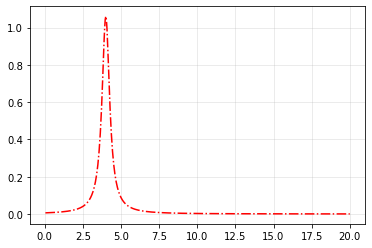

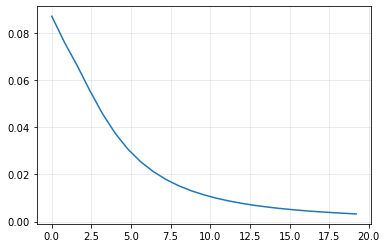

In [21]:
A,A2 = 1.0,1.0
M2 = 5.0

# index = 1 # single-peak BW 
# A = 1.0
# M = 2.0
# Gamma = 0.5
# Gamma2 = 0

# index = 2 # gaussian
# M = 2.5
# Gamma, Gamma2 = 0.4, 0

# index = 3  # double-peak BW 
# M, M2 = 2.0, 5.0
# Gamma, Gamma2 = 0.5, 0.5

# index = 4  # double-peak gaussian
# M,M2 = 2, 6
# Gamma, Gamma2 = 0.4,0.4

index = 5 # Lorenzian
M = 4
Gamma, Gamma2 = 0.3, 0



baseline = (4 * A * Gamma * omegai/((M**2 + Gamma**2 - omegai**2)**2 + 4 * Gamma**2 * omegai**2))
if Gamma2:
    baseline += 4 * A2 * Gamma2 * omegai/((M2**2 + Gamma2**2 - omegai**2)**2 + 4 * Gamma2**2 * omegai**2)

if index%2==0:
    # baseline = eta(omegai,M,Gamma)*( 1 - eta(omegai,M + Gamma,Gamma))*rhores(omegai,M,Gamma) + eta(omegai,M + Gamma,Gamma)*rhoconst(omegai,M2) # thermal spectra
    baseline = 1/Gamma/np.sqrt(2*math.pi) * np.exp(-(omegai - M)**2 / 2/Gamma**2)
    if Gamma2:
        baseline += 1/Gamma2/np.sqrt(2*math.pi) * np.exp(-(omegai - M2)**2 / 2/Gamma2**2)

if index%5==0:
    baseline = 1/Gamma/math.pi/(1 + ((omegai - M)/Gamma)**2)

plt.plot(omegai,baseline,'r-.')
plt.grid(axis='both', alpha=.3)

plt.show()

Dtau = D(taui,omegai,baseline) #+ torch.randn(taul)*1e-4

# target = np.loadtxt('cor_100_0.001.txt')

plt.plot(taui,Dtau,'-')
plt.grid(axis='both', alpha=.3)
plt.show()

np.savetxt('correlatorsBW/rho-{}.txt'.format(index), baseline, delimiter=',') 
np.savetxt('correlatorsBW/Dtau-{}.txt'.format(index), np.transpose([taui,Dtau]), delimiter=',') 


## produce many random specrtra

In [ ]:
# D_data = taui
# D_noise = taui
for i in range(1,96):
    index = 5 + i
    A = np.random.rand()*0.9 + 0.1  # 0.1, 1.0
    A2 = np.random.rand()*0.9 + 0.1
    M = np.random.rand()*2.5 + 0.5  # 0.5, 3.0
    deltaM = np.random.rand()*2.5
    M2 = M + deltaM # delta M = 0, 2.5
    M3 = M2 + deltaM # delta M = 0, 2.5
    Gamma = np.random.rand()*0.4 + 0.1 # 0.1, 0.5
    Gamma2 = np.random.binomial( n=1, p= 0.4) *0.4 + 0.1 # 0.1, 0.5
    Gamma3 = 0

    baseline = (4 * A * Gamma * omegai/((M**2 + Gamma**2 - omegai**2)**2 + 4 * Gamma**2 * omegai**2))
    if Gamma2:
        baseline += 4 * A2 * Gamma2 * omegai/((M2**2 + Gamma2**2 - omegai**2)**2 + 4 * Gamma2**2 * omegai**2)
    if Gamma3:
        baseline += 4 * A2 * Gamma3 * omegai/((M3**2 + Gamma3**2 - omegai**2)**2 + 4 * Gamma3**2 * omegai**2)

    # baseline = 1/(Gamma*math.pi) *(1 + (omegai - M)**2 / Gamma**2)**(-1)
    # baseline += 1/(Gamma*math.pi) *(1 + (omegai - M2)**2 / Gamma**2)**(-1)
    Dtau = D(taui,omegai,baseline) #+ torch.randn(taul)*1e-4

    # plt.plot(taui,Dtau,'-')

    # D_data = np.column_stack((D_data,Dtau))
    # ln = round(np.log(Dtau.min()))
    # noise = np.random.randn(taul) * 10** ln * 50
    # D_noise = np.column_stack((D_noise,Dtau + noise))

    # np.savetxt('correlatorsBW/rho-{}.txt'.format(index), baseline, delimiter=',') 
    # np.savetxt('correlatorsBW/Dtau-{}.txt'.format(index), np.transpose([taui.cpu(),Dtau.cpu(), delimiter=',') 
    
    plt.plot(omegai,baseline,'-.')
    plt.grid(axis='both', alpha=.3)

plt.show()
# np.savetxt('Dtau-tr.txt', D_data, delimiter=',') 
# np.savetxt('Dtau-noise.txt', D_noise, delimiter=',') 


In [3]:
# save same noise
noise = np.random.randn(taul)
i = 2
while i<7 :
    order = 10**(-i)
    noise1 = noise*order
    np.savetxt('correlatorsBW/noise-{}.txt'.format(i), noise1, delimiter=',') 
    i += 1

# add noise

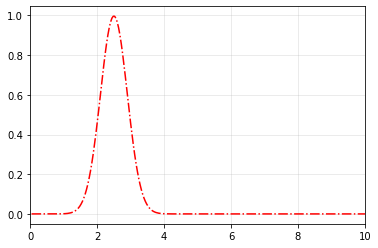

In [19]:
# 
np.savetxt('MEM/MEMdata/rho-{}.txt'.format(index), baseline, delimiter=',') 

Data_tau = taui

plt.plot(omegai,baseline,'r-.')
plt.grid(axis='both', alpha=.3)
plt.xlim([0,10])
plt.show()

for j in [2,3,4,5,6,10]:
    Data = []
    Data.append(Data_tau)
    epsilon = 10**(-j)
    if j == 10:
        epsilon = 0
    for i in range(20):
        Dtau_noise = []
        if (i == 0) and (j!=10):
            noise = np.loadtxt('correlatorsBW/noise-{}.txt'.format(j), delimiter=',', unpack=True)
            target_noise = noise*taui/dtaui * D(taui,omegai,baseline)
            Dtau_noise = D(taui,omegai,baseline) + target_noise
        else:
            Dtau_noise = D(taui,omegai,baseline) + np.random.randn(taul)*epsilon * D(taui,omegai,baseline)* taui/dtaui
        Data.append(Dtau_noise.copy())
        # plt.plot(taui,Dtau_noise,'-')
        # plt.xlim([10,18])
        # plt.ylim([-0.01,0])
        # plt.grid(axis='both', alpha=.3)

    np.savetxt('MEM/MEMdata/Dtau{}-noise{}.txt'.format(index,j), np.transpose(Data), delimiter=',') 

    # plt.show()



In [5]:
noise = np.loadtxt('correlatorsBW/noise-{}.txt'.format(3), delimiter=',', unpack=True)
target_noise = noise*taui/dtaui * D(taui,omegai,baseline)
Dtau_noise = D(taui,omegai,baseline) + target_noise

noise_mem = np.loadtxt('MEM/MEMdata/Dtau{}-noise{}.txt'.format(3,3),delimiter=',', unpack=True)

#check same noise
print(Dtau_noise - noise_mem[1,:])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
